## libstempo tutorial: simulating residuals with toasim

#### Michele Vallisneri, vallis@vallis.org, 2014/10/31

This notebook demonstrates the `libstempo` module `toasim`, which allows the simple simulation of various kinds of noise.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from __future__ import print_function
import sys

import numpy as N
import libstempo as T
import libstempo.plot as LP, libstempo.toasim as LT

T.data = T.__path__[0] + '/data/' # example files

In [3]:
print("Python version   :",sys.version.split()[0])
print("libstempo version:",T.__version__)
print("Tempo2 version   :",T.libstempo.tempo2version())

Python version   : 3.8.8
libstempo version: 2.3.5
Tempo2 version   : 2020.7.1


We open up a NANOGrav par/tim file combination with `libstempo`, and plot the residuals. 

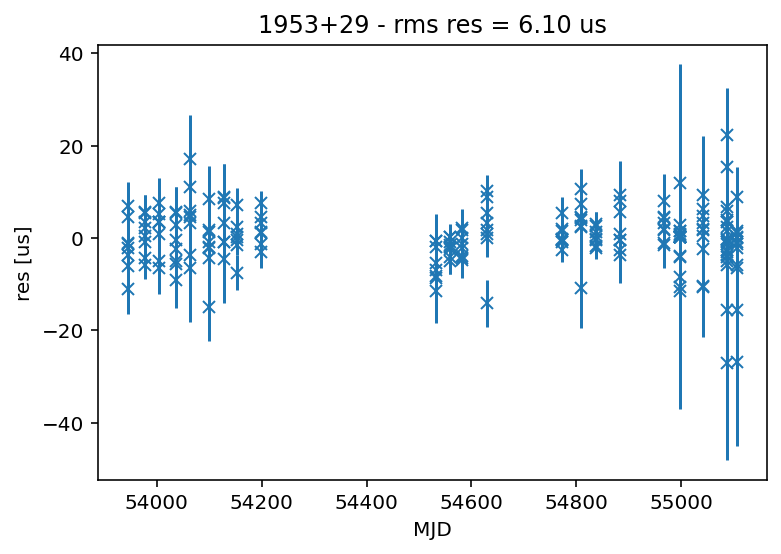

In [4]:
psr = T.tempopulsar(parfile = T.data + 'B1953+29_NANOGrav_dfg+12.par',
                    timfile = T.data + 'B1953+29_NANOGrav_dfg+12.tim')
LP.plotres(psr)

We now remove the computed residuals from the TOAs, obtaining (in effect) a perfect realization of the deterministic timing model. The pulsar parameters will have changed somewhat, so `make_ideal` calls `fit()` on the pulsar object. 

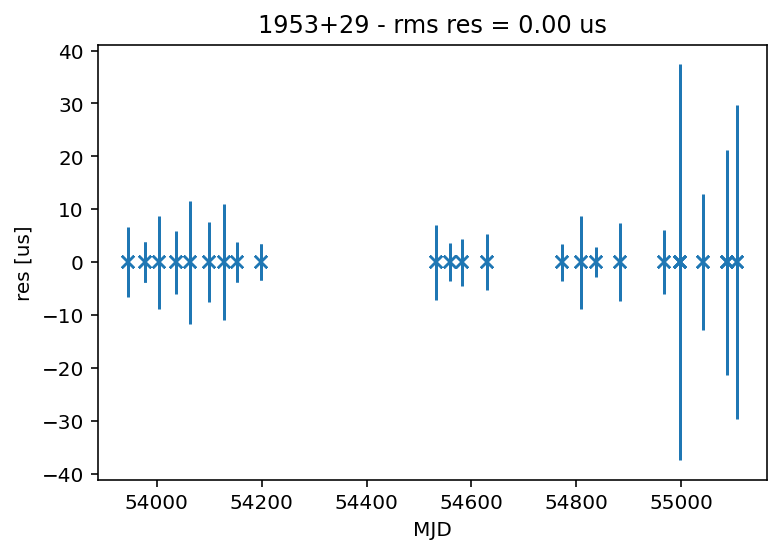

In [5]:
LT.make_ideal(psr)
LP.plotres(psr)

We now add a single line of noise at $10^{6.5}$ Hz, with an amplitude of 10 us. We also put back radiometer noise, with rms amplitude equal to 1x the nominal TOA errors.

All the noise-generating commands take an optional argument `seed` that will reseed the numpy pseudorandom-number generator, so you are able to reproduce the same instance of noise. However, if you issue several noise-generating commands in sequence, you should use different seeds. 

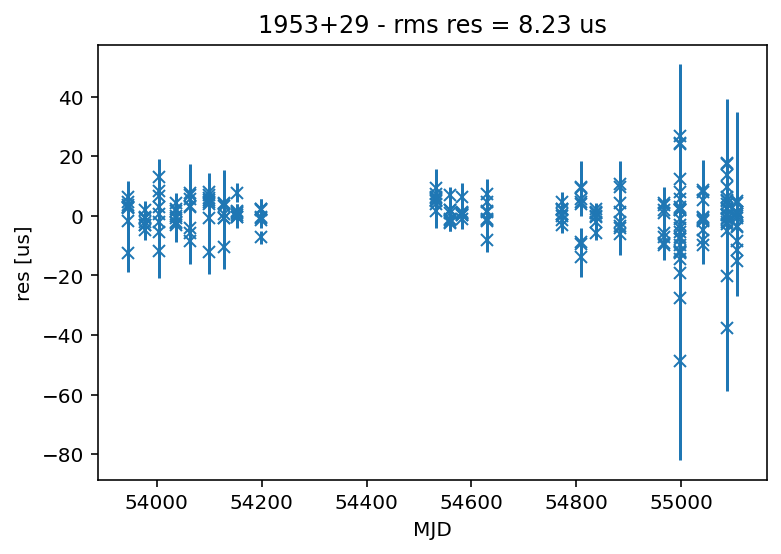

In [6]:
#LT.add_line(psr,f=10**6.5,A=1e-5)
LT.add_efac(psr,efac=1.0,seed=1234)
LP.plotres(psr)

We could also add EQUAD quadrature noise (with `add_equad`) or its coarse-grained version (with `add_jitter`), but instead we prefer some red noise of "GW-like" amplitude $10^{-12}$ and spectral slope $\gamma = -3$.

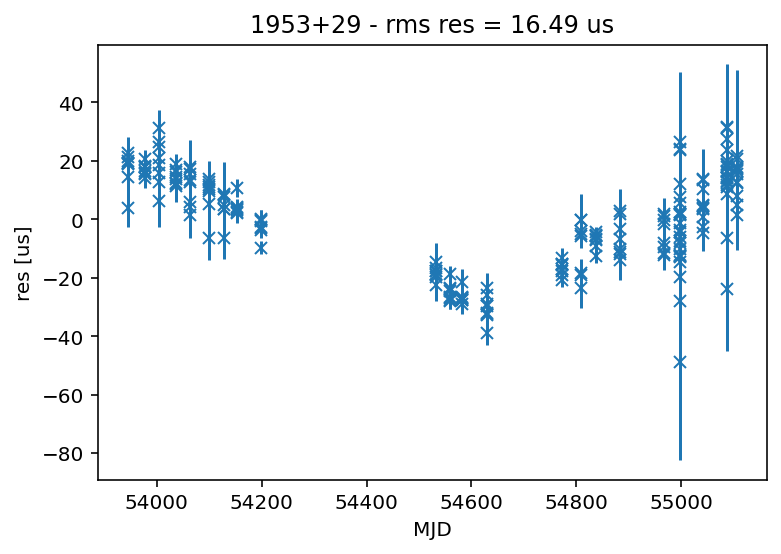

In [7]:
LT.add_rednoise(psr,1e-12,3)
LP.plotres(psr)

Or, we may add a GW background as simulated by the tempo2 GWbkgrd plugin (see the docstring below).

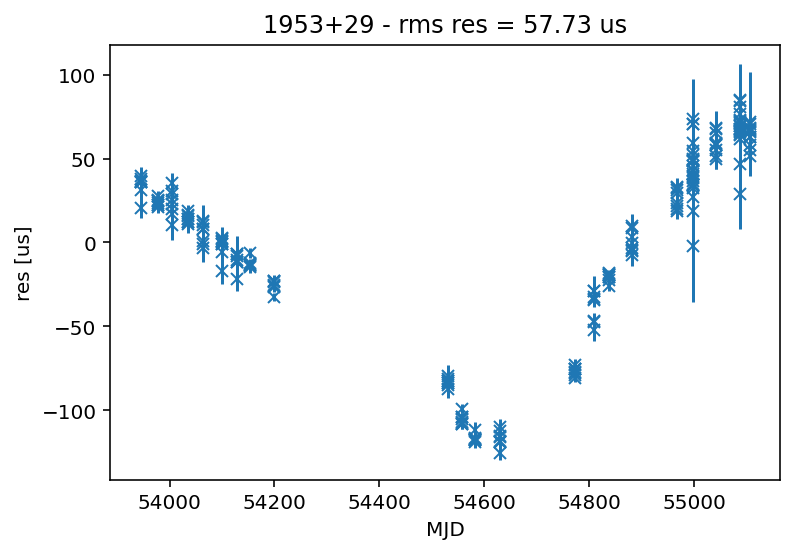

In [8]:
LT.add_gwb(psr,flow=1e-8,gwAmp=5e-12)
LP.plotres(psr)

In [9]:
help(LT.add_gwb)

Help on function add_gwb in module libstempo.toasim:

add_gwb(psr, dist=1, ngw=1000, seed=None, flow=1e-08, fhigh=1e-05, gwAmp=1e-20, alpha=-0.66, logspacing=True)
    Add a stochastic background from inspiraling binaries, using the tempo2
    code that underlies the GWbkgrd plugin.
    
    Here 'dist' is the pulsar distance [in kpc]; 'ngw' is the number of binaries,
    'seed' (a negative integer) reseeds the GWbkgrd pseudorandom-number-generator,
    'flow' and 'fhigh' [Hz] determine the background band, 'gwAmp' and 'alpha'
    determine its amplitude and exponent, and setting 'logspacing' to False
    will use linear spacing for the individual sources.
    
    It is also possible to create a background object with
    
    gwb = GWB(ngw,seed,flow,fhigh,gwAmp,alpha,logspacing)
    
    then call the method gwb.add_gwb(pulsar[i],dist) repeatedly to get a
    consistent background for multiple pulsars.
    
    Returns the GWB object



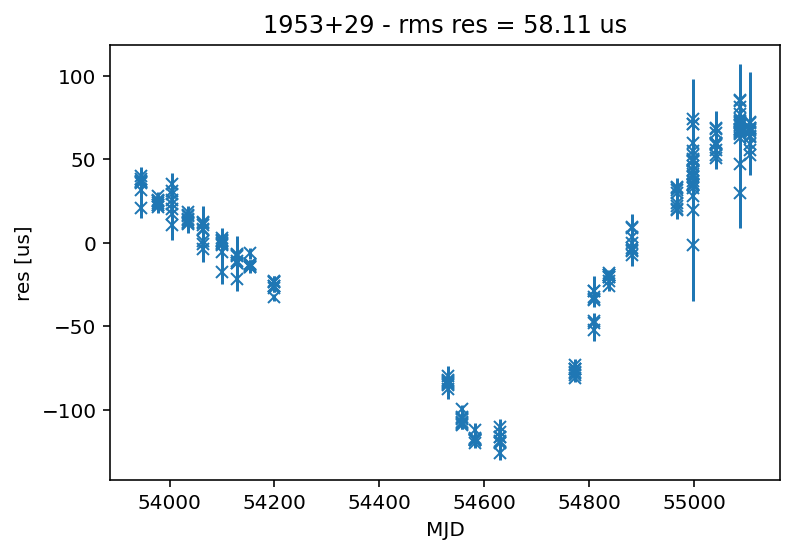

In [10]:
LT.createGWB([psr],Amp=5e-15,gam=13./3.)
LP.plotres(psr)

Refitting will remove some of the power.

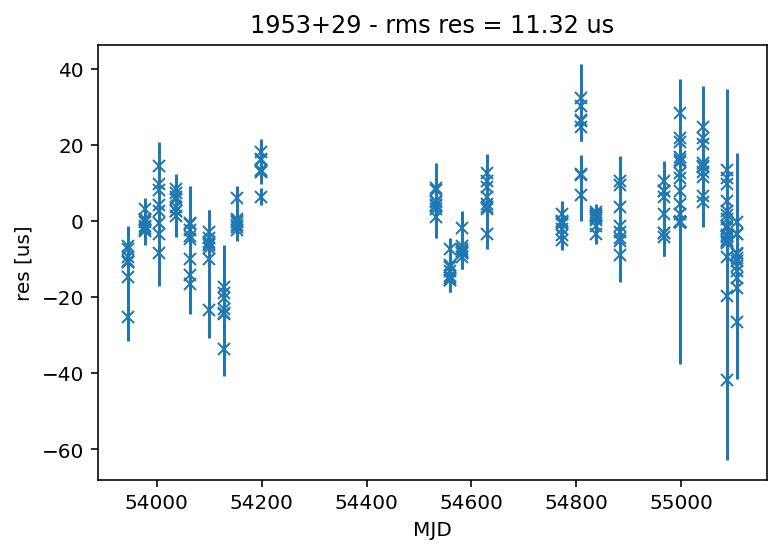

In [11]:
psr.fit()
LP.plotres(psr)

All done! We can save the resulting par and tim file, and analyze them with a favorite pipeline.

In [12]:
psr.savepar('B1953+29-simulate.par')
psr.savetim('B1953+29-simulate.tim')

Note that currently the tim file that is output by tempo2 has a spurious "`MODE 1`" line that tempo2 does not like upon reloading. To erase it, you can do

In [13]:
T.purgetim('B1953+29-simulate.tim')

And if we reload the files we get pack the same thing...

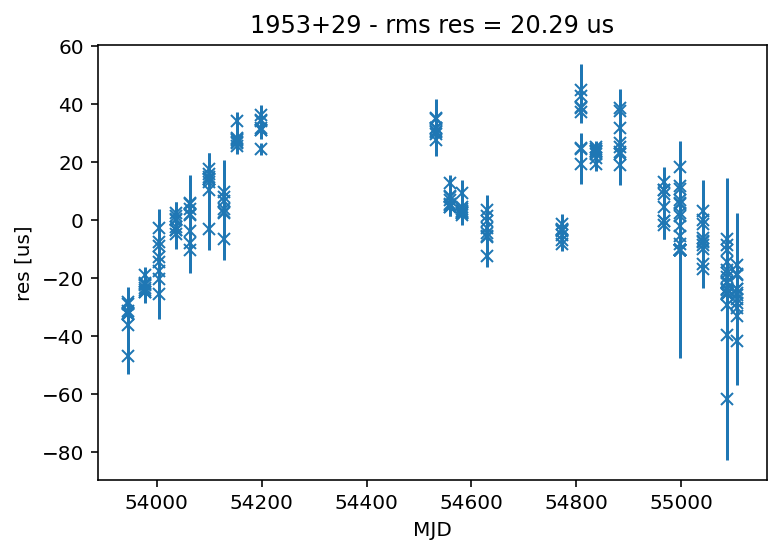

In [14]:
psr2 = T.tempopulsar(parfile = 'B1953+29-simulate.par',
                     timfile = 'B1953+29-simulate.tim')
LP.plotres(psr2)

It's also possible to obtain a perfect realization of the timing model described in a par file without a tim file, by specifying a new set of observation times (in MJD) and errors (in us). The observation frequency, observatory, and flags can also be specified (see the docstring below).

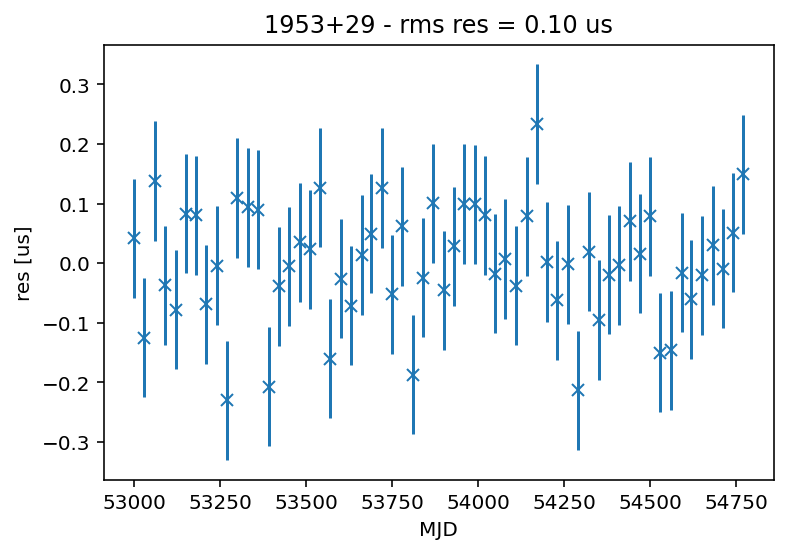

In [15]:
psr = LT.fakepulsar(parfile=T.data+'B1953+29_NANOGrav_dfg+12.par',
                    obstimes=N.arange(53000,54800,30)+N.random.randn(60),  # observe every 30+-1 days
                    toaerr=0.1)

LT.add_efac(psr,efac=1.0,seed=1234)
LP.plotres(psr)

In [16]:
help(LT.fakepulsar)

Help on function fakepulsar in module libstempo.toasim:

fakepulsar(parfile, obstimes, toaerr, freq=1440.0, observatory='AXIS', flags='', iters=3)
    Returns a libstempo tempopulsar object corresponding to a noiseless set
    of observations for the pulsar specified in 'parfile', with observations
    happening at times (MJD) given in the array (or list) 'obstimes', with
    measurement errors given by toaerr (us).
    
    A new timfile can then be saved with pulsar.savetim(). Re the other parameters:
    - 'toaerr' needs to be either a common error, or a list of errors
       of the same length of 'obstimes';
    - 'freq' can be either a common observation frequency in MHz, or a list;
       it defaults to 1440;
    - 'observatory' can be either a common observatory name, or a list;
       it defaults to the IPTA MDC 'AXIS';
    - 'flags' can be a string (such as '-sys EFF.EBPP.1360') or a list of strings;
       it defaults to an empty string;
    - 'iters' is the number of iterati

Rather than generating fake TOAs you might want to calculate a pulsar's phase at a particular set of times. Using the `tempopulsar` object you can input an arbitrary set of observation times and use the residuals to get the pulsar's relative phase. For example:

In [20]:
# create a set of times (in MJD)
obstimes = N.arange(53000, 54800, 10, dtype=N.float128)
toaerr = 1e-3  # set the (probably arbitrary) errors in the times (us)
observatory = "ao"  # the observatory
obsfreq = 1440.0  # the observation frequency (MHz)

psr = T.tempopulsar(
    parfile="B1953+29-simulate.par",
    toas=obstimes,
    toaerrs=toaerr,
    observatory=observatory,
    obsfreq=obsfreq,
    dofit=False,
)

# get the phases in cycles (mod 1) referenced to the initial observation time
phases = psr.phaseresiduals(removemean=False)

The observation times can be input as an array of astropy Time objects. The TOA error values, observatory values, and observation frequencies, can also be arrays of the same length as array of observation times.

If you want to extract phases referenced to a particular epoch, observatory and frequency, you can use the `refphs` argument to the `residuals` (or `phaseresiduals`) method of the `tempopulsar` object. For example, to reference the phase to an epoch of 52973 at the solar system barycentre you could use:

In [22]:
phaseref = psr.phaseresiduals(removemean="refphs", epoch=52973.0, site="@")

**Note**: this can also be set by using a parameter file containing the line `REFPHS TZR` and having that values `TZRMJD`, `TZRSITE` and `TZRFREQ` set.